# Problem Set 6 : Naive Bayes

Partners: Katie Goulding & Aneesha Nanda (thank you Ott!!)

In [2]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Part 1: Loading Data

In [57]:
sample_df = pd.DataFrame()
sample_df['Books'] = ['Shakespeare', 'Of Mice and Men', 'The Gift of Fire', 'The Giver']
sample_df['Number of Pages'] = ['NaN','109', '87', 'NaN']
sample_df.to_csv('sample_df.csv', index=False)
sample_data = pd.read_csv('sample_df.csv')

In [58]:
data = pd.read_csv('rotten-tomatoes.csv')
working, testing = train_test_split(data, test_size=0.20, random_state=42)
testing.to_csv('testing.csv', index = False)
del(testing)

# Part 2: Exploring Data

In [97]:
#print(working.head)
print("Number of missing 'Fresh' data:", working['fresh'].isna().sum())
print("Number of missing 'Quote' data:", working['quote'].isna().sum())
print("Values of Evaluation:", working['fresh'].unique())
print("Number of 'Fresh & Rotten' ratings:", (working['fresh']).value_counts())
print("Number of white spaces in quotes:", len(working['quote']) - len(working['quote'].str.strip()))
print("Least number of words in a quote:", working.quote.str.len().min())
print("Most number of words in a quote:", working.quote.str.len().max())
print("Average number of words in a quote:", round(working.quote.str.len().sum())/(working.quote.str.len().size))
print("Number of Duplicated Reviews:", len(working[working.duplicated()]))

Number of missing 'Fresh' data: 0
Number of missing 'Quote' data: 0
Values of Evaluation: ['fresh' 'rotten' 'none']
Number of 'Fresh & Rotten' ratings: fresh     6682
rotten    4052
none        19
Name: fresh, dtype: int64
Number of white spaces in quotes: 0
Least number of words in a quote: 6
Most number of words in a quote: 256
Average number of words in a quote: 121.49009578722217
Number of Duplicated Reviews: 386


In [6]:
# Function to clean data
def cleanData(data):
    data.fresh.dropna()
    data.quote.dropna()
    data = data[(data['quote']!= " ")]
    data = data.drop_duplicates()

# Part 3: Naive Bayes

In [7]:
# Bag of Words Implementation
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df = 0, binary = True)
words = vectorizer.fit_transform(working.quote.values)
words = words.toarray()

In [8]:
# Train/Test split
x_train, x_test, y_train, y_test, train_quotes, test_quotes = train_test_split(words, working.fresh.values, 
                                                                               working.quote.values, 
                                                                               train_size = 0.80, test_size=0.20, 
                                                                               random_state = 42)



In [9]:
# Unconditional probabilities
fresh_prob = np.log(np.mean(y_train=='fresh'))
rotten_prob = np.log(np.mean(y_train=='rotten'))

print("Fresh Rating Probabilities:", fresh_prob)
print("Rotten Rating Probabilities:", rotten_prob)

Fresh Rating Probabilities: -0.4765818330039113
Rotten Rating Probabilities: -0.9751875981083782


In [98]:
# Conditional probabilities
x_fresh = x_train[y_train == 'fresh']
x_rotten = x_train[y_train == 'rotten']

x_fresh_probs = np.log(x_fresh.mean(axis=0))
x_rotten_probs = np.log(x_rotten.mean(axis=0))

# Replace infinty values with arbitrary values
from numpy import inf
x_fresh_probs_inf = np.where(x_fresh_probs== -inf)
x_rotten_probs_inf = np.where(x_rotten_probs== -inf)

x_fresh_probs[x_fresh_probs_inf] = -10000
x_rotten_probs[x_rotten_probs_inf] = -10000



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [11]:
# Compute log likelihood of classification
log_likelihood_fresh = fresh_prob + np.apply_along_axis(sum, 1, x_fresh_probs * x_test)
log_likelihood_rotten = rotten_prob + np.apply_along_axis(sum, 1, x_rotten_probs * x_test) 

# Accuracy
preds = log_likelihood_fresh > log_likelihood_rotten
final_outcome = y_test == "fresh"
print("The accuracy for Fresh rating is:", np.mean(preds == (y_test == 'fresh')))

# Confusion Matrix
cm = confusion_matrix(final_outcome, preds)
print(cm)



The accuracy for Fresh rating is: 0.705718270571827
[[ 430  380]
 [ 253 1088]]


# Part 4: Interpretation

In [12]:
# Select 30 most frequent words and classifications
num = words.sum(axis=0)
freq_words = np.array(vectorizer.get_feature_names())
freq_words = freq_words[num > 30]
difference = x_fresh_probs - x_rotten_probs
goodness = difference[num > 30]
best_words = pd.Series(goodness, index=freq_words)

fresh_words = best_words.sort_values(ascending = False)
rotten_words = best_words.sort_values(ascending = True)

print("Words that are Fresh:", fresh_words.head(10))
print("Words that are Rotten:", rotten_words.head(10))

Words that are Fresh: delight        9994.784128
masterpiece       2.614910
superb            2.592437
witty             2.497127
funniest          2.140452
complex           2.104084
today             2.104084
thanks            2.066344
impact            2.066344
touching          2.027123
dtype: float64
Words that are Rotten: unfortunately   -3.899803
dull            -2.323155
empty           -2.108044
fails           -1.735368
problem         -1.715001
lacks           -1.630008
wrong           -1.597218
worst           -1.566446
flat            -1.563317
flick           -1.479435
dtype: float64


Based on the 30 most frequent words found in my Bag of Words, the word "delight" seems to have the highest weight for a "Fresh" rating. For a "Rotten" rating, the word "unfortunately" seems to have the highest weight. These two words were found to be frequent in the BOW and had a heavy influence if the rating would be Fresh and Rotten. Based on how the probabilities have been set up, if it is greater than 0, it weighs heavily as a "Fresh" rating (and if it is less than 0, it is classified as rotten). 

In [13]:
# Find misclassified quotes in reviews
misclassified = (preds!=final_outcome)
quotes = test_quotes[misclassified]
print(quotes[:5])   

["Despite the presence of all these action-flick cliches, In the Line of Fire works. Sure, it's no more than a formula movie, but it's an effective formula movie."
 "It's acted out in the secondary emotional register of the glass menagerie: whimsical, delicate, idiosyncratic, barmy."
 'There are a number of small, unexpectedly funny moments in A Christmas Story, but you have to possess the stamina of a pearl diver to find them.'
 "As Carrey's celebrated rubber does its patented act, the flick turns into a gyrational marathon -- mildly funny but seriously exhausting."
 "First he made Ed Wood, a tribute to the man fondly recalled as the worst movie director of all time. Now Tim Burton seems to have made a tribute to Wood's work."]


These quotes may have been misclassified due to the fact that the data contains single quotes from extracted from the full ones. It is difficult to decipher the ratings based on a few sentences since we do not have the bigger picture. In addition to this, there could be an equal number of "fresh" and "rotten" words (or a very slim difference between the two) that could confuse the classifier. Based on this, it is not uncommon to see some quotes that have been misclassified.

# Part 5: Naive Bayes with Smoothing

In [33]:
# NB model implementation
def fitNB(train_quotes, train_outcomes, alpha):
    fresh_prob = np.log((np.sum(train_outcomes=='fresh') + alpha) / (len(train_outcomes)+alpha))
    rotten_prob = np.log((np.sum(train_outcomes=='rotten') + alpha) / (len(train_outcomes)+alpha))
    
    x_fresh = train_quotes[train_outcomes == 'fresh']
    x_rotten = train_quotes[train_outcomes == 'rotten']

    x_fresh_probs = np.log((x_fresh.sum(axis=0)+ alpha) / (len(x_fresh) + alpha))
    x_rotten_probs = np.log((x_rotten.sum(axis=0)+ alpha) / (len(x_rotten) + alpha))

    from numpy import inf
    x_fresh_probs_inf = np.where(x_fresh_probs== -inf)
    x_rotten_probs_inf = np.where(x_rotten_probs== -inf)

    x_fresh_probs[x_fresh_probs_inf] = -10000
    x_rotten_probs[x_rotten_probs_inf] = -10000
    
    return (fresh_prob, rotten_prob, x_fresh_probs, x_rotten_probs)

# NB prediction implementation
def predict(fresh_prob, rotten_prob, x_fresh_probs, x_rotten_probs, x_test, y_test):
    log_likelihood_fresh = fresh_prob + np.apply_along_axis(sum, 1, x_fresh_probs * x_test)
    log_likelihood_rotten = rotten_prob + np.apply_along_axis(sum, 1, x_rotten_probs * x_test) 
    preds = log_likelihood_fresh > log_likelihood_rotten
    final_outcome = y_test == "fresh"
    accuracy = np.mean(preds == (y_test == 'fresh'))
    return accuracy


In [15]:
# Test different alpha values for NB model
alpha = 0
A, B, C, D = fitNB(x_train, y_train, alpha)
print("alpha = 0:", predict(A, B, C, D, x_test, y_test))


alpha = 0.5
A, B, C, D = fitNB(x_train, y_train, alpha)
print("alpha = 0.5:", predict(A, B, C, D, x_test, y_test))

alpha = 1
A, B, C, D = fitNB(x_train, y_train, alpha)
print("alpha = 1:", predict(A, B, C, D, x_test, y_test))




/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


alpha = 0: 0.705718270571827
alpha = 0.5: 0.7373314737331473
alpha = 1: 0.7308228730822873


# Part 6: Cross-Validation

In [34]:
# Cross validation function
def cv_fold(number, k, alpha):
        k = 5
        indices = np.arange(number)
        np.random.shuffle(indices)
        chunks = np.split(indices, k)
        all_indices = set(range(number))
        acc = []
        for fold in chunks:
            test_quotes = words[fold]
            test_outcomes = working.fresh.values[fold]
            c = set(fold)
            train_set = all_indices.difference(c)
            train_array = np.array(list(train_set))

            train_quotes = words[train_array]
            train_outcomes = working.fresh.values[train_array]

            A, B, C, D = fitNB(train_quotes, train_outcomes, 0)
            accuracies = (predict(A, B, C, D, test_quotes, test_outcomes))
            acc.append(accuracies)
        return np.mean(acc)  

In [35]:
# Loop through different alpha values
alphas = np.linspace(0, 2, 10)
mean_accuracies = []
for i in alphas:
    mean_acc = cv_fold(1000, 5, i)
    mean_accuracies.append(mean_acc)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Text(0,0.5,'accuracies')

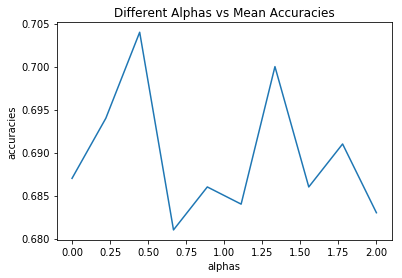

In [36]:
# Plot graph for best alpha value
import matplotlib.pyplot as plt
plt.plot(alphas, mean_accuracies)
plt.title("Different Alphas vs Mean Accuracies")
plt.xlabel("alphas")
plt.ylabel("accuracies")

Based on the plot, the most optimal alpha value for the highest accuracy is ~0.3. (I was unable to add more than 1000 samples since it slowed down the computer). 

# Part 7: Final Model Performance

In [92]:
# NB Model on Working dataset
features = words
outcome = working.fresh.values

A, B, C, D = fitNB(features, outcome, 0.3)

In [93]:
# Load in and clean Testing dataset
testing = pd.read_csv('testing.csv')
cleanData(testing)

In [94]:
# Bag of Words on Testing data
X = vectorizer.fit(working.quote.values)
X = vectorizer.transform(testing.quote.values)
X = X.toarray()


In [96]:
# Bag of Words for Testing data
test_features = X
test_outcome = testing.fresh.values
print("Testing Data Accuracy:", predict(A, B, C, D, test_features, test_outcome))

Testing Data Accuracy: 0.7764968389735961


Compared to kNN and TF-IDF from PS-04, kNN and TF-IDF had a lower accuracy score than Naive Bayes. Naive Bayes had close to a 75% accuracy for predicting a review having a Fresh or Rotten status. kNN had an accuracy score of about ~55% whereas TF-IDF had scores around ~65%. From all three algorithms, it was clear that Naive Bayes had performed the best.